In [1]:
import os
import numpy as np
import pandas as pd
from skimage import exposure
import matplotlib.pyplot as plt
import cv2
from ast import literal_eval
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import DenseNet121
import tensorflow.keras.backend as K

2021-11-07 14:11:47.368394: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-07 14:11:47.368421: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df_image = pd.read_csv('train_image_level.csv')
df_study = pd.read_csv('train_study_level.csv')

# merge two dataset for ease manipulation
df_study['id'] = df_study['id'].str.replace('_study', '')
df_study.rename({'id' : 'StudyInstanceUID'}, axis=1, inplace=True)
df_train = df_image.merge(df_study, on='StudyInstanceUID')

# create new col for label class
df_train.loc[df_train['Typical Appearance']==1, 'study_label'] = 'typical'
df_train.loc[df_train['Indeterminate Appearance']==1, 'study_label'] = 'indeterminate'
df_train.loc[df_train['Atypical Appearance']==1, 'study_label'] = 'atypical'
df_train.drop(['Negative for Pneumonia','Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance'], axis=1, inplace=True)


df_train['id'] = df_train['id'].str.replace('_image', '.png')

# split label for just getting opacity/none label
df_train['image_label'] = df_train['label'].str.split().apply(lambda x : x[0])

df_train.head(3)

,id,boxes,label,StudyInstanceUID,study_label,image_label
0,000a312787f2.png,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,typical,opacity
1,000c3a3f293f.png,NaN,none 1 0 0 1 1,ff0879eb20ed,NaN,none
2,0012ff7358bc.png,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,typical,opacity


In [3]:
all_files = []
for dirname, _, filenames in os.walk('train'):
    for filename in filenames:
        all_files.append(os.path.join(dirname, filename))

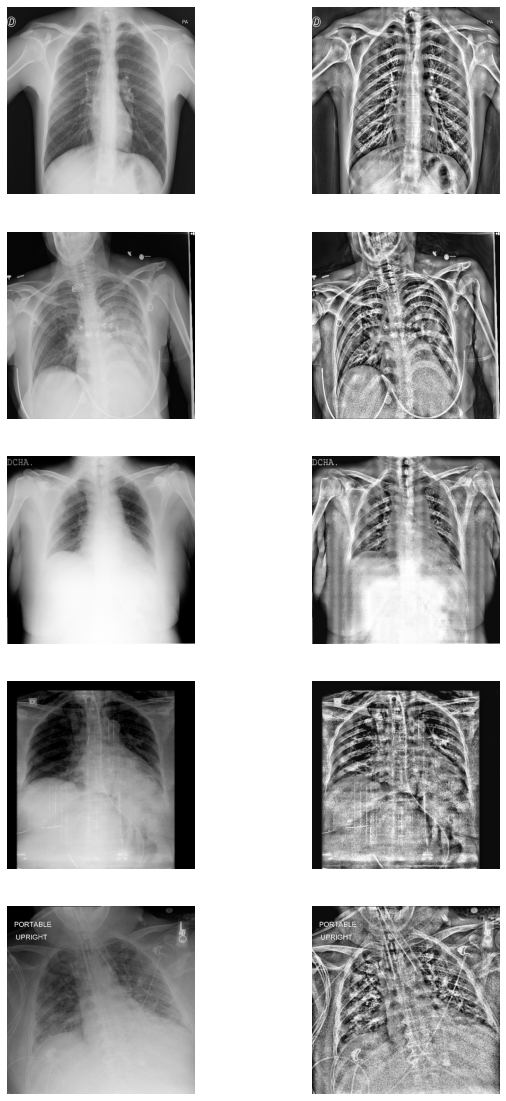

In [4]:
def preprocess_image(img):
    # python -m pip install -U scikit-image
    equ_img = exposure.equalize_adapthist(img/255, clip_limit=0.05, kernel_size=24)
    return equ_img

df_opa = df_train[df_train['image_label'] == 'opacity'].reset_index()
fig, axs = plt.subplots(5, 2, figsize=(10,20))
fig.subplots_adjust(hspace=.2, wspace=.2)
n = 5
for i in range(n):
    img = cv2.imread(os.path.join(all_files[i]))
    img_proc = preprocess_image(img)
    axs[i, 0].imshow(img)
    axs[i, 1].imshow(img_proc)
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

plt.show()

In [6]:
img_size = 224
batch_size = 16

image_generator = ImageDataGenerator(
    validation_split=0.2,
    horizontal_flip=True,
    zoom_range=0.15,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
    preprocessing_function=preprocess_image
    
)

image_generator_valid = ImageDataGenerator(validation_split=0.2, preprocessing_function=preprocess_image)

train_generator = image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory='train-512-png',
    x_col='id',
    y_col='image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='training',
    seed=23
)

valid_generator = image_generator.flow_from_dataframe(
    dataframe=df_train,
    directory='train-512-png',
    x_col='id',
    y_col='image_label',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    subset='validation',
    shuffle=False,
    seed=23
)

Found 4864 validated image filenames belonging to 2 classes.
Found 1215 validated image filenames belonging to 2 classes.


/home/roberto/anaconda3/envs/venv/lib/python3.8/site-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 255 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


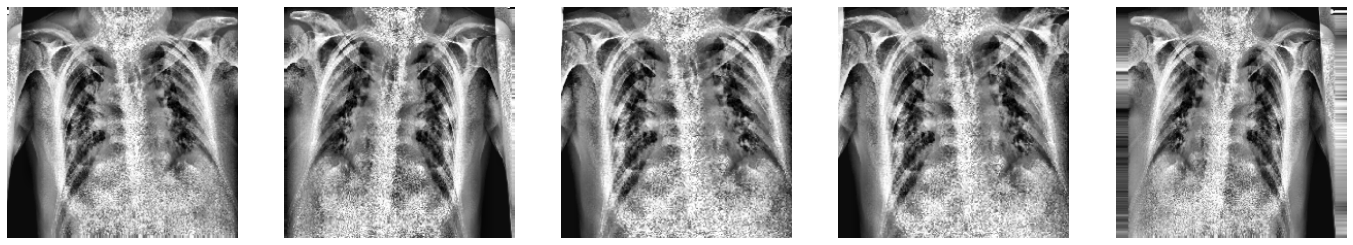

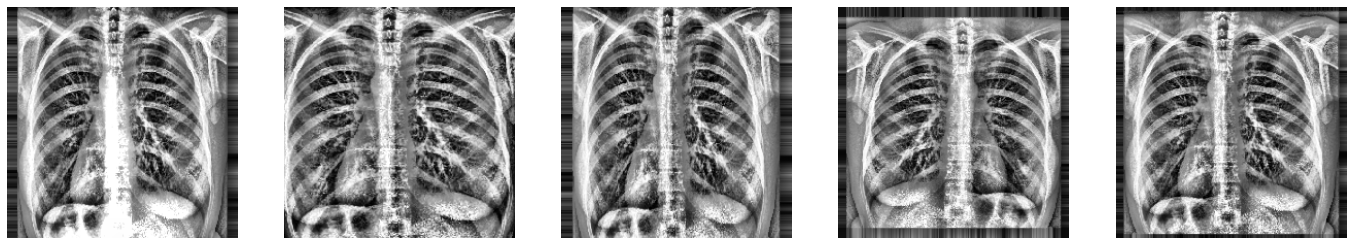

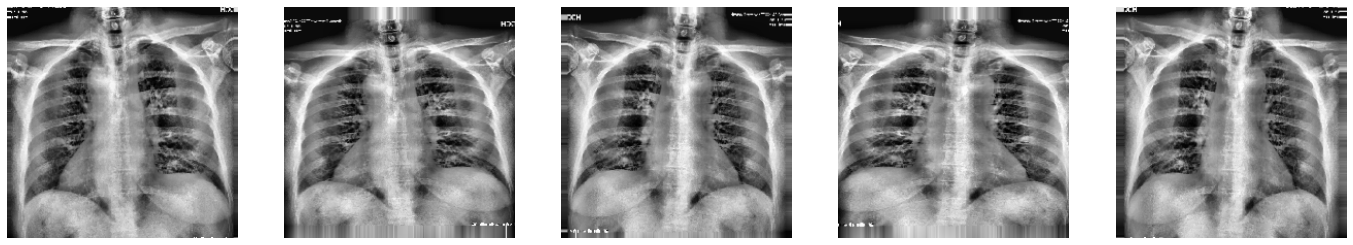

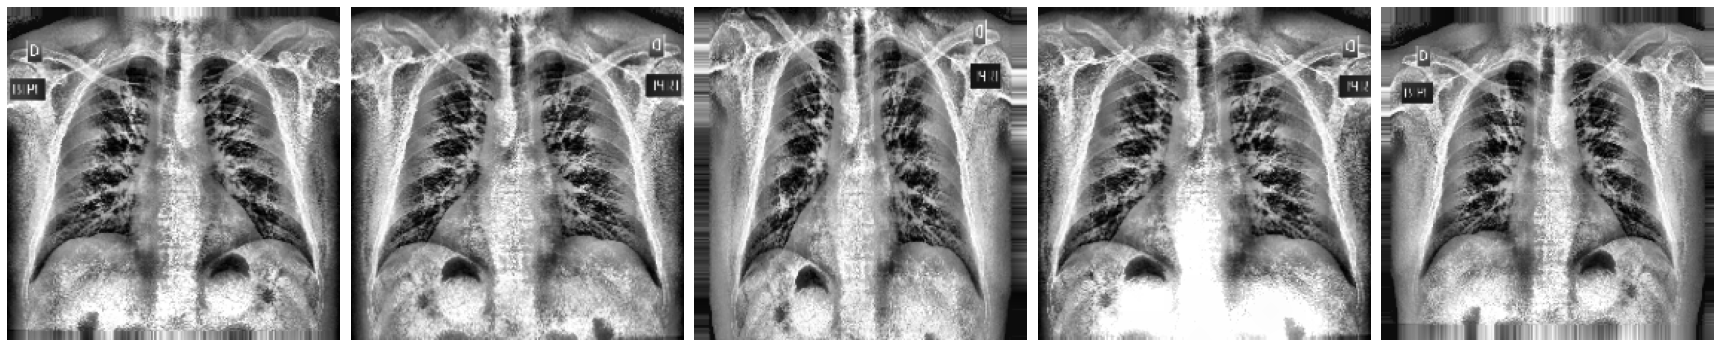

In [9]:
for j in range(4):
    aug_images = [train_generator[0][0][j] for i in range(5)]
    fig, axes = plt.subplots(1, 5, figsize=(24,24))
    axes = axes.flatten()
    for img, ax in zip(aug_images, axes):
        ax.imshow(img)
        ax.axis('off')
        
plt.tight_layout()
plt.show()

In [10]:
def load_process(img, img_size):
    img=load_img(img, target_size=(img_size, img_size))
    img=img_to_array(img)
    img=img.reshape((1, img.shape[0], img.shpa[1], img.shape[2]))
    img=preprocess_image(img)
    return img

In [13]:
chex_weights_path = 'brucechou1983_CheXNet_Keras_0.3.0_weights.h5'

pre_model = DenseNet121(weights=None, include_top=False, input_shape=(img_size, img_size,3))

out = Dense(14, activation='sigmoid')(pre_model.output)

pre_model = Model(inputs=pre_model.input, outputs=out)

pre_model.load_weights(chex_weights_path)

pre_model.trainable = False

x =  pre_model.layers[-2].output

x = GlobalAveragePooling2D()(x)

x = Dropout(0.1)(x)

output = Dense(2, activation='softmax')(x)

model = Model(pre_model.input, output)

2021-11-05 13:03:26.269496: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-11-05 13:03:26.269600: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (roberto-HP): /proc/driver/nvidia/version does not exist
2021-11-05 13:03:26.270265: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.compile(Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics='accuracy')

In [20]:
rlr = ReduceLROnPlateau(monitor='val_accuracy', 
                        factor=0.2, 
                        patience=2, 
                        verbose=1, 
                        min_delta= 1e-4, 
                        min_lr = 1e-4,
                       mode='max')
es = EarlyStopping(monitor='val_accuracy',
                  min_delta=1e-4,
                  patience=5,
                  mode='max',
                  restore_best_weights=True,
                  verbose=1)

ckp = ModelCheckpoint('model.h5', 
                      monitor='val_accuracy',
                     verbose=0,
                     save_best_only=True,
                     mode='max')

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=valid_generator,
    callbacks=[es, rlr, ckp],
    verbose=1
)

2021-11-05 13:04:54.039983: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
304/304 [==============================] - 605s 2s/step - loss: 0.6005 - accuracy: 0.6875 - val_loss: 0.6091 - val_accuracy: 0.6568
Epoch 2/20
304/304 [==============================] - 596s 2s/step - loss: 0.5636 - accuracy: 0.7150 - val_loss: 0.5895 - val_accuracy: 0.6848
Epoch 3/20
304/304 [==============================] - 598s 2s/step - loss: 0.5462 - accuracy: 0.7290 - val_loss: 0.6079 - val_accuracy: 0.6691
Epoch 4/20
304/304 [==============================] - 648s 2s/step - loss: 0.5411 - accuracy: 0.7373 - val_loss: 0.6014 - val_accuracy: 0.6757
Epoch 5/20
304/304 [==============================] - 626s 2s/step - loss: 0.5355 - accuracy: 0.7420 - val_loss: 0.5961 - val_accuracy: 0.6798
Epoch 6/20
304/304 [==============================] - 595s 2s/step - loss: 0.5315 - accuracy: 0.7473 - val_loss: 0.5639 - val_accuracy: 0.7128
Epoch 7/20
304/304 [==============================] - 594s 2s/step - loss: 0.5280 - accuracy: 0.7488 - val_loss: 0.5608 - val_accuracy: 0.7128

Fine-tuning

In [23]:
pre_model.trainable = True
model.compile(Adam(learning_rate=1e-5),
             loss='binary_crossentropy',
             metrics='accuracy')

In [ ]:

rlr2 = ReduceLROnPlateau(monitor='val_accuracy', 
                        factor=0.1,
                       patience=2,
                       verbose=1,
                       min_delta=1e-4,
                       min_lr=1e-7,
                       mode='max')

es2 = EarlyStopping(monitor='val_accuracy', 
                    min_delta=1e-4,
                   patience=7,
                   mode='max',
                   restore_best_weights=True,
                   verbose=1)

history2 = model.fit(train_generator,
                    epochs=40,
                    validation_data=valid_generator,
                    callbacks=[es2, rlr2, ckp],
                    verbose=1)

K.clear_session()

Epoch 1/40
304/304 [==============================] - 2351s 8s/step - loss: 0.8144 - accuracy: 0.6264 - val_loss: 0.6332 - val_accuracy: 0.7218
Epoch 2/40
304/304 [==============================] - 3019s 10s/step - loss: 0.6167 - accuracy: 0.7229 - val_loss: 0.5997 - val_accuracy: 0.7383
Epoch 3/40
304/304 [==============================] - 2324s 8s/step - loss: 0.5593 - accuracy: 0.7556 - val_loss: 0.6106 - val_accuracy: 0.7243
Epoch 4/40
304/304 [==============================] - 2309s 8s/step - loss: 0.5366 - accuracy: 0.7693 - val_loss: 0.5810 - val_accuracy: 0.7416
Epoch 5/40
304/304 [==============================] - 2517s 8s/step - loss: 0.5258 - accuracy: 0.7710 - val_loss: 0.5965 - val_accuracy: 0.7333
Epoch 6/40
304/304 [==============================] - 2943s 10s/step - loss: 0.5307 - accuracy: 0.7630 - val_loss: 0.5837 - val_accuracy: 0.7374

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
Epoch 7/40
304/304 [==============================] -